# Initialization


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.exceptions import DataConversionWarning
import itertools

Hiding data conversion warnings generated by standard scaler.
Standard scaler expects float as input and converts input to float throwing a warning message.

In [2]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


Running MLP on the entire dataset of 60K records.

In [3]:
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip')
test = pd.read_csv(test_url, compression='zip')

train.shape

(60000, 785)

In [4]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
59218,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3270,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33745,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34423,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [5]:
y_train=train.label.values
X_train=train.drop('label', axis=1).values
X_test = test.drop('label', axis=1).values
y_test = test.label.values

In [6]:
class_names = ['0', '1', '2', '3', '4', 
               '5', '6', '7', '8', '9']

# Define model

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(128,128), max_iter=200, alpha=1e-4,
                    solver='adam', verbose=False, tol=1e-4, random_state=1,
                    learning_rate_init=.001)


MLP is highly sensitive to scaling. Therefore, I am using standard scaler to scale the data. Use a pipeline to scale and fit the model.

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [8]:
clf = make_pipeline(StandardScaler(), mlp)


# Model fit and validate using Stratified KFold

In [9]:
def model_score(model, X, y):
    score = model.score(X, y)
    return score

In [10]:
def model_fit(model, X_train, y_train):
    cv_scores = []
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
    for train, val in kfold.split(X_train, y_train):
        model.fit(X_train[train], y_train[train])
        cv_score = model_score(model, X_train[val], y_train[val])
        print("Validation score for classifier... %.4f" % cv_score)
        cv_scores.append(cv_score)
    print("Done")
    return cv_scores

In [11]:
cv_scores = model_fit(clf, X_train, y_train)


Validation score for classifier... 0.9712
Validation score for classifier... 0.9724
Validation score for classifier... 0.9714
Done


# Evaluate the model

In [12]:
print("Generating test scores for classifier... ")

score = model_score(clf, X_test, y_test)
print("Test score for classifier... %.4f" % score)


Generating test scores for classifier... 
Test score for classifier... 0.9730


# Make predictions

In [13]:
predictions = clf.predict(X_test)
predictions[0]

7

In [14]:
y_test[0]

7

In [15]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img.reshape(28, 28), cmap=plt.cm.binary)

    predicted_label = predictions_array
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)


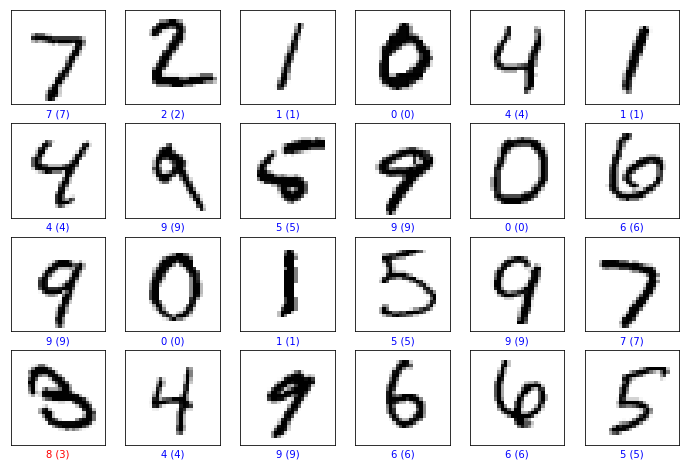

In [16]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 4
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(i, predictions, y_test, X_test)
plt.show()

# Visualization of MLP weights
Acknowledgments - https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py

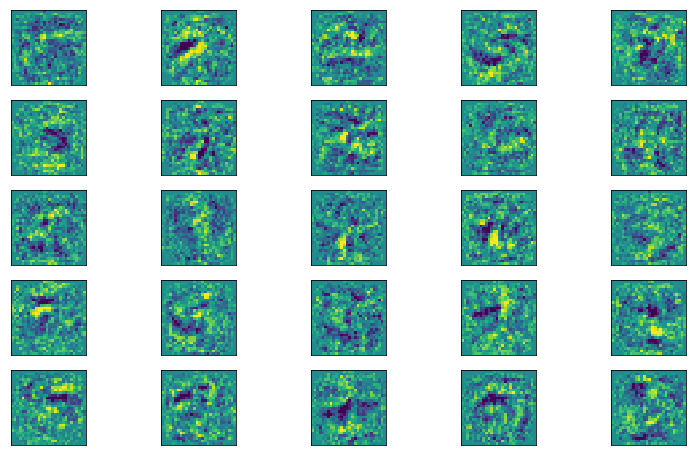

In [17]:
fig, axes = plt.subplots(5, 5, figsize=(13, 8))
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.grid(False)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()